# VAERS Dataset을 통한 Covid vaccine EDA


### 들어가며

2020년 초반부터 퍼지기 시작한 Covid19 바이러스, 지금은 너무나 우리의 일상에 가까워져 있는 상태이다. 다행스럽게도 빠른 백신 개발을 통해 1년여만에 여러 회사에서 백신을 만들어냈다. 하지만 백신도입초기 연일 뉴스에서는 백신투약 후 생기는 부작용, 심지어 사망에 이르렀다는 보도들이 나오면서 백신 자체에 대한 의구심이 생기는 것은 어쩌면 당연한 일이라고 생각한다. 
본 필자의 경우에도 고령의 할머니를 모시고 있는 상황에서 백신에 부작용에 대한 데이터를 접하게 되었고, 이를 분석하여 어떤 insight를 얻을 수 있는지 궁금증이 생기게 되어 이렇게 EDA를 진행하게 되었다.

### VAERS Data에 대하여

- 해당 자료는 `vaers.hhs.gov`에 공지되어 있는 면책조항(?)이다.

##### Disclaimer
`VAERS accepts reports of adverse events and reactions that occur following vaccination. Healthcare providers, vaccine manufacturers, and the public can submit reports to the system. While very important in monitoring vaccine safety, VAERS reports alone cannot be used to determine if a vaccine caused or contributed to an adverse event or illness. The reports may contain information that is incomplete, inaccurate, coincidental, or unverifiable. In large part, reports to VAERS are voluntary, which means they are subject to biases. This creates specific limitations on how the data can be used scientifically. Data from VAERS reports should always be interpreted with these limitations in mind.

The strengths of VAERS are that it is national in scope and can quickly provide an early warning of a safety problem with a vaccine. As part of CDC and FDA’s multi-system approach to post-licensure vaccine safety monitoring, VAERS is designed to rapidly detect unusual or unexpected patterns of adverse events, also known as “safety signals.” If a safety signal is found in VAERS, further studies can be done in safety systems such as the CDC’s Vaccine Safety Datalink (VSD) or the Clinical Immunization Safety Assessment (CISA) project. These systems do not have the same scientific limitations as VAERS, and can better assess health risks and possible connections between adverse events and a vaccine.

Key considerations and limitations of VAERS data:

Vaccine providers are encouraged to report any clinically significant health problem following vaccination to VAERS, whether or not they believe the vaccine was the cause.
Reports may include incomplete, inaccurate, coincidental and unverified information.
The number of reports alone cannot be interpreted or used to reach conclusions about the existence, severity, frequency, or rates of problems associated with vaccines.
VAERS data is limited to vaccine adverse event reports received between 1990 and the most recent date for which data are available.
VAERS data do not represent all known safety information for a vaccine and should be interpreted in the context of other scientific information.`



_필자의 경우 영어를 잘 못하기 때문에 구글 번역기로 번역시켜보았다._
- 한국어 번역 (google translator)

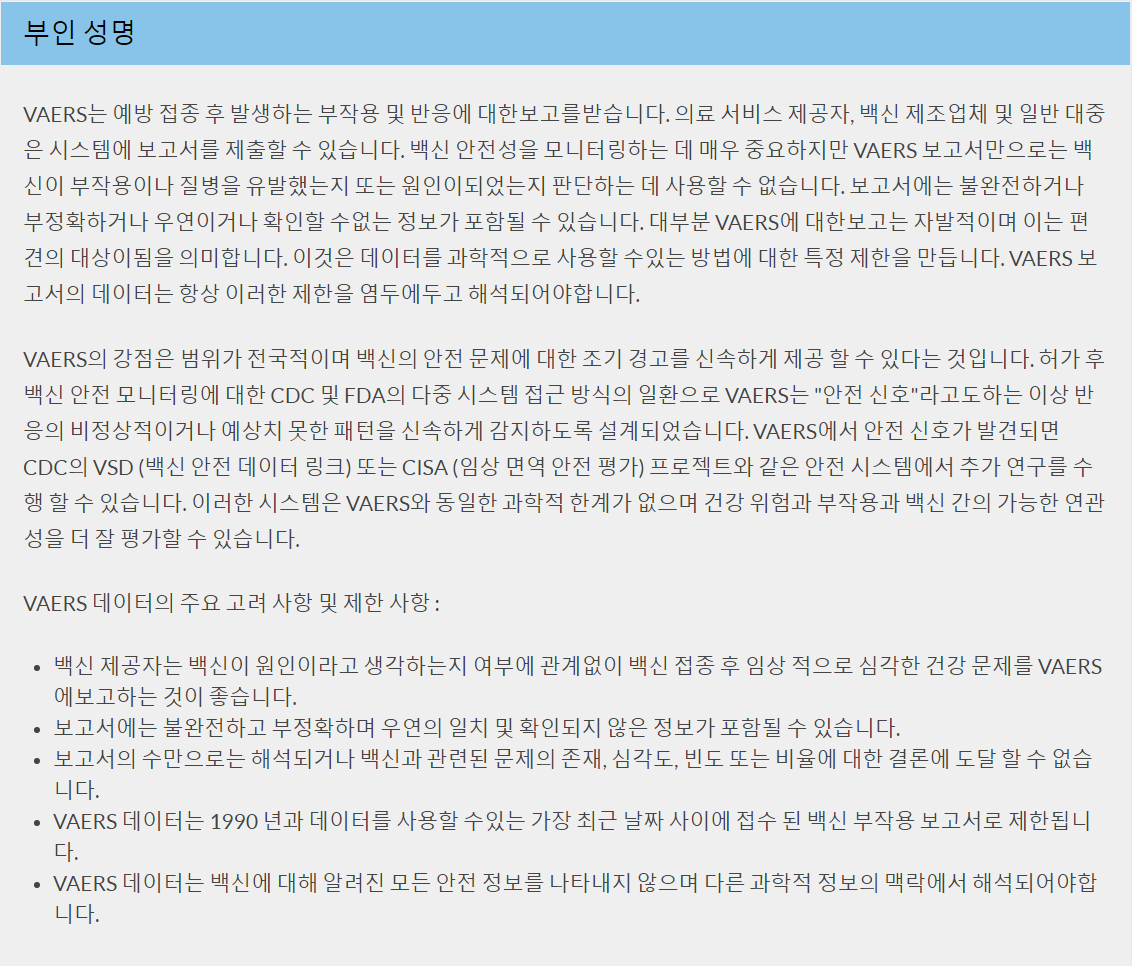

대충 이해해보자면 '백신과 부작용에 대한 보고서이지만, 백신이 부작용에 대한 원인인지는 판단할 수 없다'라고 말하는 것 같다.

지금 이 면책사항을 읽어보면서 호준 멘토님이 말씀하셨던 명언
Correlation is NOT Causation 이 생각났다. 하지만 우리에게 주어진 것은 Dataset 뿐이므로 각 feature들 간의 상관성과 경향성에 대해서만 분석해보도록 하자.

In [1]:
# 시각화에 필요한 package들
import chardet # csv에 encoding error로 인해 encode type을 찾기 위한 package
import opendatasets as od

# data분석도구
import numpy as np
import pandas as pd

# 시각화도구
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#기타 설정
plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄을 본 필자가 항상 쓰는 방법입니다. matplotlib의 기본 scheme 말고 seaborn scheme을 세팅하고, 일일이 graph의 font size를 지정할 필요 없이 seaborn의 font_scale을 사용하면 편합니다.

#ignore warnings

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# csv data가 있는 path
input_path = './2021VAERSData'

In [3]:
# 2021VAERSDATA.csv file이 encoding error를 발생시켜 encode type을 찾기 위한 code
# f.realine() 은 모든 row의 encode type을 체크하는 듯 하다.
# or read() if the file is small.

with open(f'{input_path}/2021VAERSDATA.csv', 'rb') as f:
    result = chardet.detect(f.read(52223))  # read( number ) 는 특정 number row의 encode type을 확인한다.
    print(result['encoding'])
#위의 경우 52222 position에서 error발생

ISO-8859-1


In [4]:
vaers_df = pd.read_csv(f'{input_path}/2021VAERSDATA.csv', encoding='ISO-8859-1').drop_duplicates('VAERS_ID').set_index('VAERS_ID')

vaers_df.head()

,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
VAERS_ID,,,,,,,,,,,,,,,,,,,,,
916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom
916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,NaN,...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy"""
916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish
916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,NaN,...,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom..."
916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,NaN,...,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na


In [5]:
#증상 Dataframe의 경우 추후 병합을 위해 중복 ID값을 버린다..

symptom_df = pd.read_csv(f'{input_path}/2021VAERSSYMPTOMS.csv').drop_duplicates('VAERS_ID').set_index('VAERS_ID')
symptom_df.head()

,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
VAERS_ID,,,,,,,,,,
916600,Dysphagia,23.1,Epiglottitis,23.1,NaN,NaN,NaN,NaN,NaN,NaN
916601,Anxiety,23.1,Dyspnoea,23.1,NaN,NaN,NaN,NaN,NaN,NaN
916602,Chest discomfort,23.1,Dysphagia,23.1,Pain in extremity,23.1,Visual impairment,23.1,NaN,NaN
916603,Dizziness,23.1,Fatigue,23.1,Mobility decreased,23.1,NaN,NaN,NaN,NaN
916604,Injection site erythema,23.1,Injection site pruritus,23.1,Injection site swelling,23.1,Injection site warmth,23.1,NaN,NaN


In [6]:
vax_df = pd.read_csv(f'{input_path}/2021VAERSVAX.csv', encoding='ISO-8859-1').drop_duplicates('VAERS_ID').set_index('VAERS_ID')

In [7]:
vax_df.head()

,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
VAERS_ID,,,,,,,
916600,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA))
916601,COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA))
916602,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
916603,COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA))
916604,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA))


## Vaersdata features

| 변수명 | 설명 | 변수명 | 설명 |
| :-- | :-- | :-- | :-- |
| VAERS_ID | VAERS 식별 번호( PRIMARY ) | RECVDATE | 보고된 날짜 |
| STATE | 거주지 | AGE_YRS | 나이 |
| CAGE_YR | Calculated age of patient in years | CAGE_MO | Calculated age of patient in months |
| SEX | 성별 | RPT_DATE | Date Form Completed | SYMPTOM_TEXT | 보고 된 증상 |
| DIED | 사망여부 | DATEDIED | MedDRA dictionary version number 5 |
| L_THREAT | 중증질환 보유 여부 | ER_VISIT | 응급실 또는 의사 방문 |
| HOSPITAL | 입원여부 | HOSPDAYS | 입원일수|
| DISABLE | Disability| RECOVD|회복여부|
|VAX_DATE|백신접종일|ONSET_DATE|이상반응 발생일|
|NUMDAYS|발현까지 걸린 일수(ONSET_DATE-VAX_DATE)|LAB_DATA|진단 데이터|
|V_ADMINBY|백신투여시설 유형|V_FUNDBY|백신구메에 사용되는 자금 유형|
|OTHER_MEDS|복용중인 약물|CUR_ILL|보유질병|
|HISTORY|만성 또는 장기간의 건강 상태|PRIOR_VAX|이전 예방접종 이력|
|SPLTTYPE|제조업체/면역프로젝트 보고서 번호|FORM_VERS|VERS 양식 버전|
|TODAYS_DATE|오늘날짜|BIRTH_DEFECT|선청성 기형 또는 선천적 질병|
|OFC_VISIT|의사 또는 기타 의료제공시설 방문|ER_ED_VISIT|응급실 또는 긴급치료|
|ALLERGIES|약물, 식품 또는 기타 제품에 대한 알레르기|


## Vaerssymptoms features

| 변수명 | 설명 | 변수명 | 설명 |
| :-- | :-- | :-- | :-- |
|VAERS_ID| VAERS 식별번호 |
|SYMPTOM<\<n>>| 이상반응 MedDRA 용어| 
|SYMPTOMVERSION<\<n>>| MedDRA사전 version |


## Vaersvax features
| 변수명 | 설명 | 변수명 | 설명 |
| :-- | :-- | :-- | :-- |
|VAERS_ID| VAERS 식별번호| VAX_TYPE| 백신유형|
|VAX_MANU| 백신 제조업체|VAX_LOT|제조업체의 백신 로트|
|VAX_DOSE_SERIES|투여횟수|VAX_ROUTE|접종경로|
|VAX_SITE|접종장소|VAX_NAME|접종이름|

### Feature의 수가 굉장히 많아서 주요 feature를 골라 진행할 예정이다.
- AGE_YRS
- L_THREAT
- RECOVD
- BIRTH_DEFECT
- ALLERGIES
- HISTORY
- SEX...

_위의 features를 주요하게 다루며 target label인 DIED와의 상관관계를 찾아보자._

## 모든 테이블을 병합(merge)

In [8]:
merge_outer = pd.merge(vaers_df, vax_df, how='inner',on= 'VAERS_ID')
merge_outer = pd.merge(merge_outer,symptom_df, how='inner',on='VAERS_ID')

merge_outer.head(20)

,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,...,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
VAERS_ID,,,,,,,,,,,,,,,,,,,,,
916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,NaN,...,Dysphagia,23.1,Epiglottitis,23.1,NaN,NaN,NaN,NaN,NaN,NaN
916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,NaN,...,Anxiety,23.1,Dyspnoea,23.1,NaN,NaN,NaN,NaN,NaN,NaN
916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,NaN,...,Chest discomfort,23.1,Dysphagia,23.1,Pain in extremity,23.1,Visual impairment,23.1,NaN,NaN
916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,NaN,...,Dizziness,23.1,Fatigue,23.1,Mobility decreased,23.1,NaN,NaN,NaN,NaN
916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,NaN,...,Injection site erythema,23.1,Injection site pruritus,23.1,Injection site swelling,23.1,Injection site warmth,23.1,NaN,NaN
916605,01/01/2021,TX,40.0,40.0,NaN,M,NaN,"Adverse Events: Inflammation in the eye, confu...",NaN,NaN,...,Chills,24.0,Confusional state,24.0,Eye inflammation,24.0,Headache,24.0,Laboratory test,24.0
916606,01/01/2021,NV,44.0,44.0,NaN,F,NaN,patient called back the next day and stated he...,NaN,NaN,...,Pharyngeal swelling,23.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
916607,01/01/2021,KS,50.0,50.0,NaN,M,NaN,SEVERE chills approximately 13-14 hours after ...,NaN,NaN,...,Abdominal pain,23.1,Chills,23.1,Sleep disorder,23.1,NaN,NaN,NaN,NaN
916608,01/01/2021,OH,33.0,33.0,NaN,M,NaN,Nasal congestion and diarrhea,NaN,NaN,...,Diarrhoea,23.1,Nasal congestion,23.1,NaN,NaN,NaN,NaN,NaN,NaN


## 1. 1 Null data check

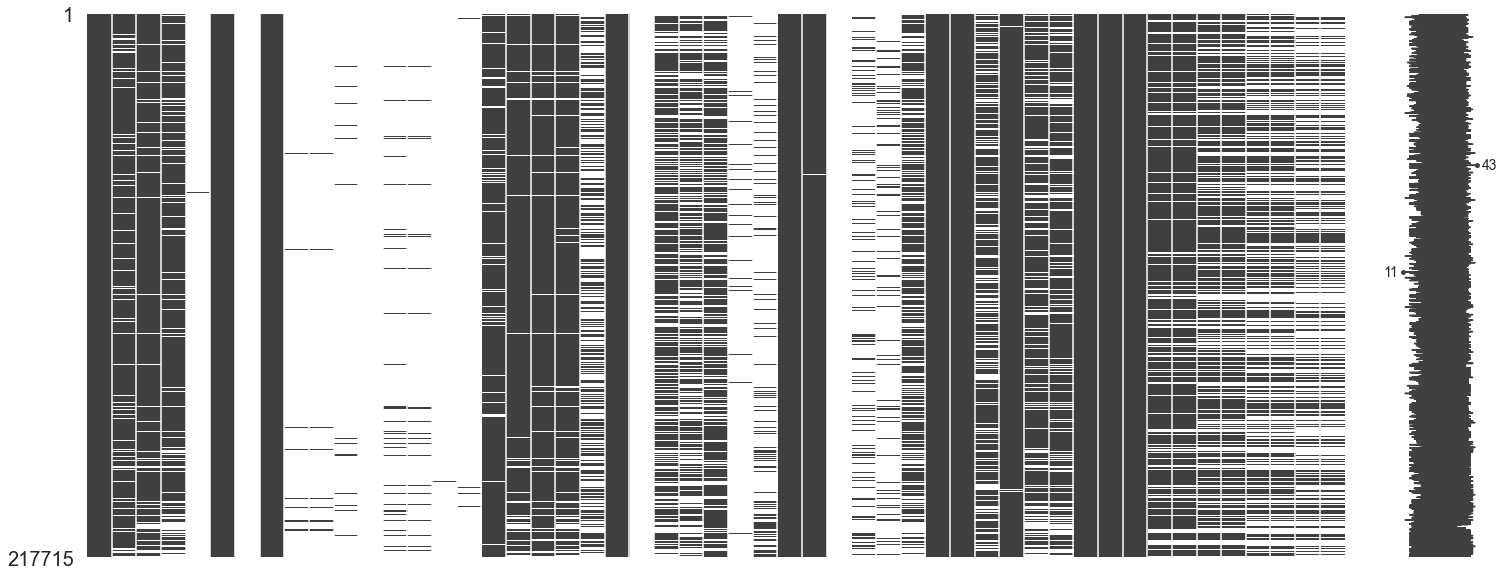

In [9]:
msno.matrix(merge_outer)
plt.show()

- `missingno`를 통해 시각화하였을 때 NaN타입의 데이터가 굉장히 많음을 알 수 있다.
- 결측치를 어떻게 해결해야할지 곰곰히 생각해봐야할 것 같다.

In [10]:
target_df = merge_outer

for col in target_df.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100*(target_df[col].isnull().sum() / target_df[col].shape[0]))
    print(msg)

column:   RECVDATE	 Percent of NaN value: 0.00%
column:      STATE	 Percent of NaN value: 10.11%
column:    AGE_YRS	 Percent of NaN value: 7.98%
column:    CAGE_YR	 Percent of NaN value: 15.63%
column:    CAGE_MO	 Percent of NaN value: 99.80%
column:        SEX	 Percent of NaN value: 0.00%
column:   RPT_DATE	 Percent of NaN value: 99.93%
column: SYMPTOM_TEXT	 Percent of NaN value: 0.02%
column:       DIED	 Percent of NaN value: 98.09%
column:   DATEDIED	 Percent of NaN value: 98.25%
column:   L_THREAT	 Percent of NaN value: 98.24%
column:   ER_VISIT	 Percent of NaN value: 99.99%
column:   HOSPITAL	 Percent of NaN value: 94.20%
column:   HOSPDAYS	 Percent of NaN value: 96.16%
column:     X_STAY	 Percent of NaN value: 99.92%
column:    DISABLE	 Percent of NaN value: 98.71%
column:     RECOVD	 Percent of NaN value: 8.86%
column:   VAX_DATE	 Percent of NaN value: 6.22%
column: ONSET_DATE	 Percent of NaN value: 4.08%
column:    NUMDAYS	 Percent of NaN value: 8.63%
column:   LAB_DATA	 Percen

## 2. Data cleansing and fillna

1. `age_yrs`를 기준으로 통합하고 `age_yrs`가 `NaN`일 경우 `cage_yr`과 `cage_mo`를 통해 계산한다.

In [11]:
merge_outer['AGE_YRS'].fillna(merge_outer['CAGE_YR']+merge_outer['CAGE_MO'], inplace=True)
merge_outer = merge_outer[:][merge_outer['AGE_YRS'].notnull()] # age가 nan인 경우 드랍

In [12]:
print(len(merge_outer.index.unique()))
len(merge_outer.index)

200454


200454

2. target label인 DIED는 사망자를 제외하고는 응답하지 않아 NaN이 된 것이니 0으로 채워주도록 하자. 
    - DIED가 NaN이지만 DATEDIE가 NaN이 아닌 경우도 사망으로 처리한다. #구현하지 못함...

In [13]:
# DIED feature fillna
merge_outer['DIED'] = merge_outer['DIED'].map(lambda x: 1 if x == 'Y' else 0)

3. L_THREAT, BIRTH_DEFECT, ER_VISIT, HOSPITAL, X_STAY, ER_ED_VISIT의 경우에도 응답을 하지 않은 경우는 0, Y는 1로 치환하여 데이터를 처리해준다.
    - `.unique()`를 통해 확인해보면 yes or no인 것을 알 수 있다.

In [14]:
for c in merge_outer.columns:
    print(c, merge_outer[c].unique())

RECVDATE ['01/01/2021' '01/02/2021' '01/03/2021' '01/04/2021' '01/05/2021'
 '01/06/2021' '01/07/2021' '01/08/2021' '01/09/2021' '01/10/2021'
 '01/11/2021' '01/12/2021' '01/13/2021' '01/14/2021' '01/15/2021'
 '01/16/2021' '01/17/2021' '01/18/2021' '01/19/2021' '01/20/2021'
 '01/21/2021' '01/22/2021' '01/23/2021' '01/24/2021' '01/25/2021'
 '01/26/2021' '01/27/2021' '01/28/2021' '01/29/2021' '01/30/2021'
 '01/31/2021' '02/01/2021' '02/02/2021' '02/03/2021' '02/04/2021'
 '02/05/2021' '02/06/2021' '02/07/2021' '02/08/2021' '02/09/2021'
 '02/10/2021' '02/11/2021' '02/12/2021' '02/13/2021' '02/14/2021'
 '02/15/2021' '02/16/2021' '02/17/2021' '02/18/2021' '02/19/2021'
 '02/20/2021' '02/21/2021' '02/22/2021' '02/23/2021' '02/24/2021'
 '02/25/2021' '02/26/2021' '02/27/2021' '02/28/2021' '03/01/2021'
 '03/02/2021' '03/03/2021' '03/04/2021' '03/05/2021' '03/06/2021'
 '03/07/2021' '03/08/2021' '03/09/2021' '03/10/2021' '03/11/2021'
 '03/12/2021' '03/13/2021' '03/14/2021' '03/15/2021' '03/16/2021'
 

DIED [0 1]
DATEDIED [nan '10/18/2020' '01/01/2021' '01/03/2021' '01/02/2021' '01/04/2021'
 '12/31/2020' '07/28/2018' '01/05/2021' '12/28/2020' '01/06/2021'
 '01/07/2021' '01/08/2021' '12/29/2020' '12/26/2020' '01/08/2001'
 '12/27/2020' '12/25/2020' '12/22/2020' '01/10/2021' '12/30/2020'
 '01/09/2021' '01/11/2021' '01/12/2021' '01/13/2021' '12/21/2020'
 '01/14/2021' '01/15/2021' '10/10/2020' '01/16/2021' '01/17/2021'
 '12/01/2020' '01/18/2021' '01/19/2021' '01/20/2021' '02/07/2019'
 '01/21/2021' '12/23/2020' '01/22/2021' '01/24/2021' '01/25/2021'
 '01/23/2021' '10/09/2019' '01/26/2021' '01/27/2021' '01/28/2021'
 '01/29/2021' '01/30/2021' '01/31/2021' '02/01/2021' '02/02/2021'
 '02/03/2021' '02/04/2021' '02/05/2021' '02/07/2021' '02/06/2021'
 '02/08/2021' '11/13/2020' '10/27/2020' '02/09/2021' '02/10/2021'
 '02/11/2021' '02/12/2021' '02/13/2021' '02/14/2021' '02/15/2021'
 '02/16/2021' '02/17/2021' '02/18/2021' '02/19/2021' '02/20/2021'
 '02/21/2021' '02/22/2021' '02/14/2014' '02/23/2021'

OTHER_MEDS ['None' 'Patient residing at nursing facility. See patients chart.' 'none'
 ... 'PROBIOTICS NOS; VITAMINS NOS' 'Xyzal, birth control, Pepcid, Prozac'
 'LEVOTHYROXINE, ROSUVASTATIN']
CUR_ILL ['None' 'Patient residing at nursing facility. See patients chart.'
 'kidney infection' ...
 'Abstains from alcohol; Non-smoker; Penicillin allergy (Rash and facial swelling of lips, and eyes)'
 'Poison ivy rash'
 'Abstains from alcohol; Allergy to nuts; Asthma; Non-smoker']
HISTORY ['None' 'Patient residing at nursing facility. See patients chart.'
 'diverticulitis, mitral valve prolapse, osteoarthritis' ...
 'Medical History/Concurrent Conditions: Autonomic neuropathy; Clinical depression; Peripheral neuropathy; Type 1 diabetes mellitus'
 'Asthma, pollen allergies, anxiety'
 'Medical History/Concurrent Conditions: Cholecystectomy; Hysterotomy; Transient ischemic attack; Comments: no illicit drug use.']
PRIOR_VAX [nan
 'got measles from measel shot, mums from mumps shot, headaches and na

In [15]:
yes_no_col = ['L_THREAT', 'BIRTH_DEFECT', 'ER_VISIT', 'HOSPITAL', 'X_STAY', 'ER_ED_VISIT']
for c in yes_no_col:
    merge_outer[c] = merge_outer[c].map(lambda x: 1 if x == 'Y' else 0)

4. 나머지 NaN의 경우 빈공간으로 채워준다.

In [16]:
merge_outer.fillna("", inplace=True)

5. VAX_TYPE이 convid19인 경우만 사용함

In [17]:
merge_outer = merge_outer[merge_outer['VAX_TYPE'] == 'COVID19']

In [18]:
# dataset 저장

merge_outer.to_csv(f'{input_path}/my_vaers.csv')

In [30]:
my_vaers = pd.read_csv(f'{input_path}/my_vaers.csv')

## 3. Target label확인

Text(0.5, 1.0, 'DIED')

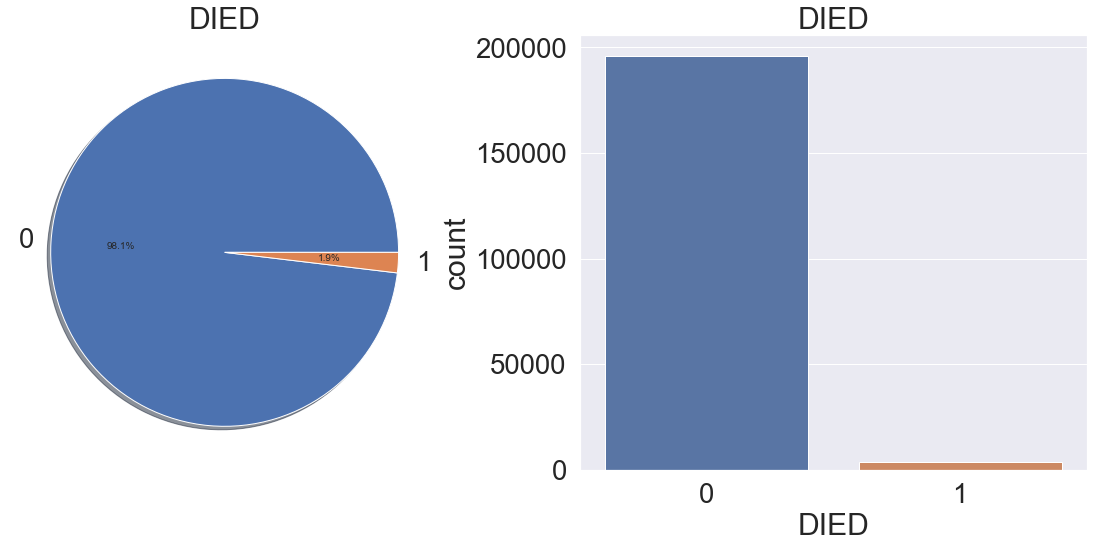

In [31]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))

my_vaers['DIED'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('DIED')
ax[0].set_ylabel('')
sns.countplot('DIED', data=my_vaers, ax=ax[1])
ax[1].set_title('DIED')

백신접종 후 사망률의 경우 1.9%정도로 나타나고 있다.
- Extra task 다른 백신의 사망률과 비교

# 가장 궁금했던 점은 백신 종류에 따른 사망률

- 백신 종류 중에서도 궁금했던 AZ 백신에 대한 정보는 없었지만 PFIZER와 MODERNA 등 안정성이 좋다고 하는 백신에 대해서라도 정보를 얻어보자

In [32]:
my_vaers['VAX_NAME'].unique()

array(['COVID19 (COVID19 (MODERNA))',
       'COVID19 (COVID19 (PFIZER-BIONTECH))',
       'COVID19 (COVID19 (UNKNOWN))', 'COVID19 (COVID19 (JANSSEN))'],
      dtype=object)

                                     DIED
VAX_NAME                                 
COVID19 (COVID19 (JANSSEN))           261
COVID19 (COVID19 (MODERNA))          1896
COVID19 (COVID19 (PFIZER-BIONTECH))  1592
COVID19 (COVID19 (UNKNOWN))            20


([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

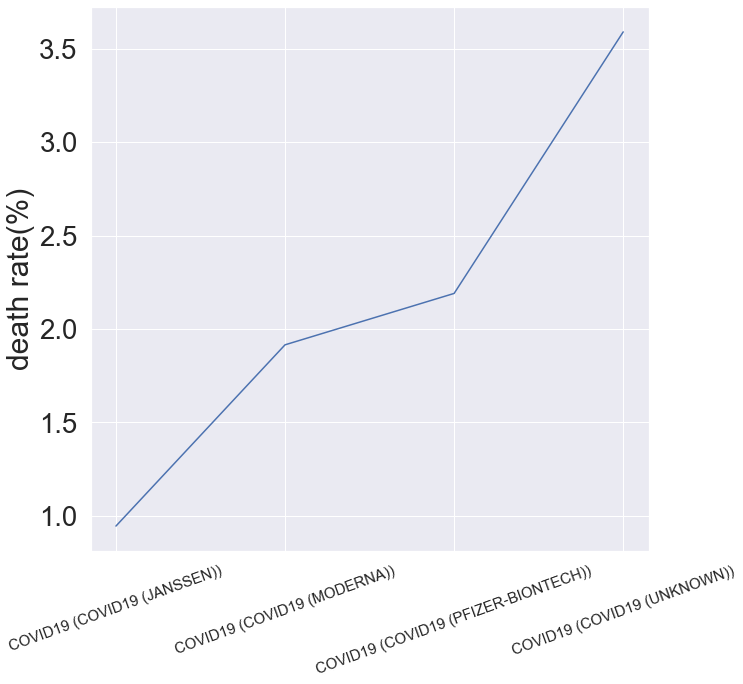

In [71]:
fig = plt.figure(figsize=(10, 10))
print(my_vaers[['DIED', 'VAX_NAME']].groupby(['VAX_NAME']).sum())
fig.figsize = (20, 20)
plt.plot(my_vaers[['DIED', 'VAX_NAME']].groupby(['VAX_NAME']).sum()/my_vaers[['DIED', 'VAX_NAME']].groupby(['VAX_NAME']).count()*100)
plt.ylabel('death rate(%)')
plt.xticks(fontsize=15, rotation=20)

#### 표본집단의 크기가 다르기 때문에 정확한 비교는 어렵겠지만 안정성면에서는 JANSSEN > MODERNA > PFIZER > UNKWON 순

## AGE와 DIED의 상관관계

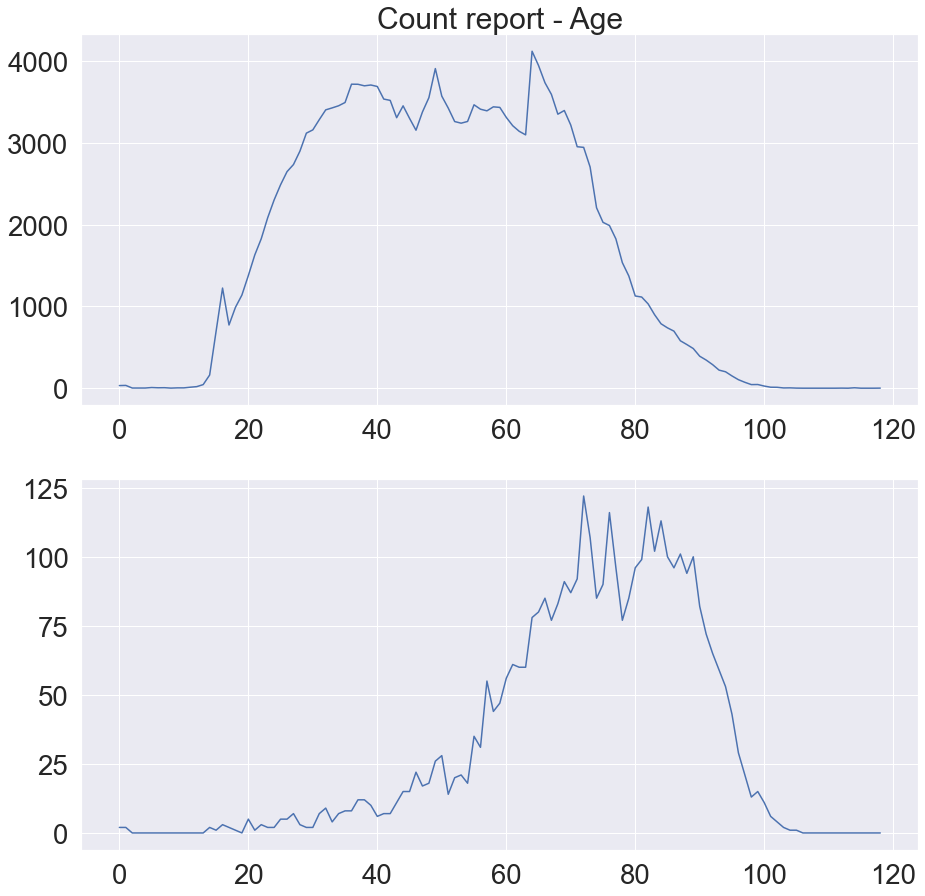

In [72]:
age_range = pd.cut(merge_outer['AGE_YRS'], np.arange(0, 120))
f, ax = plt.subplots(2, 1, figsize=(15, 15))
ax[0].set_title('Count report - Age')
ax[0] = ax[0].plot(merge_outer['DIED'].groupby(age_range).count())

ax[1] = ax[1].plot(merge_outer['DIED'].groupby(age_range).sum())
# plt.xticks(np.arange(0, 120, 5), fontsize=20)
plt.show()
# merge_outer[['AGE_YRS', 'DIED']].groupby(pd.cut(merge_outer['AGE_YRS'], np.arange(0, merge_outer['AGE_YRS'].max()+1, 5),as_index=True).count()

In [22]:
merge_outer[['SEX', 'DIED']].groupby(['SEX'], as_index=True).sum()

,DIED
SEX,
F,1661
M,2087
U,21


(array([0, 1, 2]), [Text(0, 0, 'F'), Text(1, 0, 'M'), Text(2, 0, 'U')])

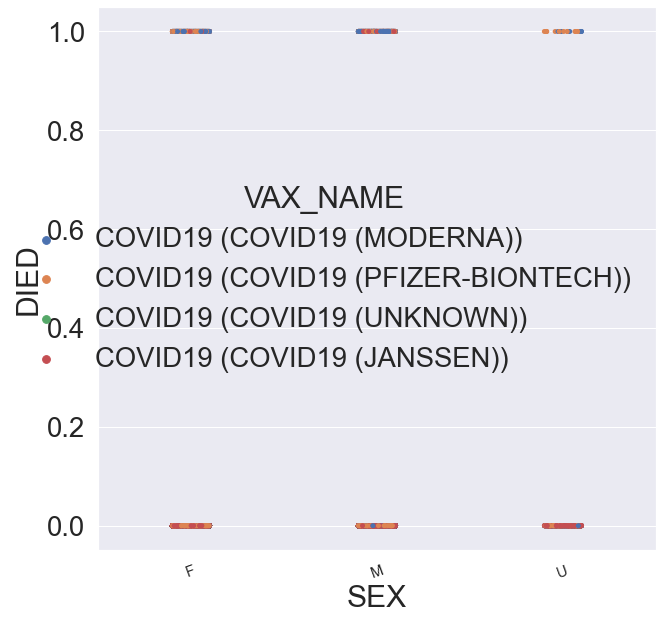

In [82]:
plt.figure(figsize=(10, 10))
sns.stripplot('SEX', 'DIED', hue='VAX_NAME', data=my_vaers)
plt.xticks(fontsize=15, rotation=20)

In [24]:

merge_outer.groupby(by='VAX_MANU').describe()
# merge_outer[['DIED', 'VAX_MANU']].groupby(by='VAX_MANU').sum()

AGE_YRS                                                \
                        count       mean        std   min   25%   50%   75%   
VAX_MANU                                                                      
JANSSEN               27600.0  44.585788  16.277659  0.00  31.0  44.0  57.0   
MODERNA               98969.0  52.916373  18.007213  0.00  38.0  53.0  67.0   
PFIZER\BIONTECH       72668.0  51.863682  18.022539  0.00  37.0  51.0  66.0   
UNKNOWN MANUFACTURER    557.0  50.263160  18.684996  0.58  35.0  51.0  64.0   

                                DIED            ... ER_ED_VISIT       \
                        max    count      mean  ...         75%  max   
VAX_MANU                                        ...                    
JANSSEN               105.0  27600.0  0.009457  ...         0.0  1.0   
MODERNA               113.0  98969.0  0.019158  ...         0.0  1.0   
PFIZER\BIONTECH       119.0  72668.0  0.021908  ...         0.0  1.0   
UNKNOWN MANUFACTURER   97.0    557.0  0.035907  ...         0.0  1.0   

                     SYMPTOMVERSION1                                         \
                               count       mean       std   min   25%   50%   
VAX_MANU                                                                      
JANSSEN                      27600.0  23.921674  0.253694  23.1  24.0  24.0   
MODERNA                      98969.0  23.881836  0.303951  23.1  24.0  24.0   
PFIZER\BIONTECH              72668.0  23.765315  0.395148  23.1  23.1  24.0   
UNKNOWN MANUFACTURER           557.0  23.877199  0.309212  23.1  24.0  24.0   

                                  
                       75%   max  
VAX_MANU                          
JANSSEN               24.0  24.0  
MODERNA               24.0  24.0  
PFIZER\BIONTECH       24.0  24.0  
UNKNOWN MANUFACTURER  24.0  24.0  

[4 rows x 80 columns]

In [25]:
# target feature만으로 새로운 Dataframe을 만들기

target_features = pd.DataFrame(merge_outer.loc[:,['AGE_YRS', 'L_THREAT', 'RECOVD', 'BIRTH_DEFECT', 'ALLERGIES', 'DIED']])
target_features

,AGE_YRS,L_THREAT,RECOVD,BIRTH_DEFECT,ALLERGIES,DIED
VAERS_ID,,,,,,
916600,33.0,0,Y,0,Pcn and bee venom,0
916601,73.0,0,Y,0,"""Dairy""",0
916602,23.0,0,U,0,Shellfish,0
916603,58.0,0,Y,0,"Diclofenac, novacaine, lidocaine, pickles, tom...",0
916604,47.0,0,N,0,Na,0
...,...,...,...,...,...,...
1316354,48.0,0,N,0,,0
1316362,39.0,0,U,0,,0
1316365,27.0,0,N,0,,0


## 결측치를 채우거나 무시할 기준을 세워보자  
  
  
1. 가장 먼저 target label인 DIED는 사망자를 제외하고는 응답하지 않아 NaN이 된 것이니 0으로 채워주도록 하자.

3. 수치형 데이터의 경우 다양하게 결측치를 처리하는 방법이 있을 것으로 보인다. 일반적으로는 평균을 많이 사용하는 듯 하지만, 여기서는 drop하는 방법으로 처리하겠다.

In [26]:
target_features['AGE_YRS'].dropna()
target_features

,AGE_YRS,L_THREAT,RECOVD,BIRTH_DEFECT,ALLERGIES,DIED
VAERS_ID,,,,,,
916600,33.0,0,Y,0,Pcn and bee venom,0
916601,73.0,0,Y,0,"""Dairy""",0
916602,23.0,0,U,0,Shellfish,0
916603,58.0,0,Y,0,"Diclofenac, novacaine, lidocaine, pickles, tom...",0
916604,47.0,0,N,0,Na,0
...,...,...,...,...,...,...
1316354,48.0,0,N,0,,0
1316362,39.0,0,U,0,,0
1316365,27.0,0,N,0,,0


In [27]:
target_features.describe()

,AGE_YRS,L_THREAT,BIRTH_DEFECT,DIED
count,199794.000000,199794.000000,199794.000000,199794.000000
mean,51.375291,0.018394,0.000571,0.018864
std,17.999120,0.134371,0.023880,0.136047
min,0.000000,0.000000,0.000000,0.000000
25%,37.000000,0.000000,0.000000,0.000000
50%,51.000000,0.000000,0.000000,0.000000
75%,66.000000,0.000000,0.000000,0.000000
max,119.000000,1.000000,1.000000,1.000000


In [28]:
target_features.corr()

,AGE_YRS,L_THREAT,BIRTH_DEFECT,DIED
AGE_YRS,1.000000,0.057897,-0.007194,0.178135
L_THREAT,0.057897,1.000000,0.021686,0.016612
BIRTH_DEFECT,-0.007194,0.021686,1.000000,-0.000232
DIED,0.178135,0.016612,-0.000232,1.000000


In [29]:
res = target_features.loc[:,['AGE_YRS', 'L_THREAT', 'BIRTH_DEFECT', 'DIED']]
res
# sns.heatmap()

,AGE_YRS,L_THREAT,BIRTH_DEFECT,DIED
VAERS_ID,,,,
916600,33.0,0,0,0
916601,73.0,0,0,0
916602,23.0,0,0,0
916603,58.0,0,0,0
916604,47.0,0,0,0
...,...,...,...,...
1316354,48.0,0,0,0
1316362,39.0,0,0,0
1316365,27.0,0,0,0
